This notebook just reads the raw csv files, joins them, drops duplicate columns, performs formatting, creates aggregate features and saves the output as a new csv file 

Workflow:
data -> imputer -> preprocess -> survival

In [1]:
import numpy as np
import pandas as pd

from load import load_table, to_csv

from utilities import get_cumulative, get_indicator, merge, add_aggregate

In [2]:
path = './Data'

In [3]:
av_tumour = load_table('av_tumour', path)
av_patient = load_table('av_patient', path)
sact_patient = load_table('sact_patient', path)
sact_tumour = load_table('sact_tumour', path)
sact_regimen = load_table('sact_regimen', path)
sact_cycle = load_table('sact_cycle', path)

print(f'AV_TUMOUR rows: {av_tumour.shape[0]}')
print(f'AV_PATIENT rows: {av_patient.shape[0]}')
print(f'SACT_PATIENT rows: {sact_patient.shape[0]}')
print(f'SACT_TUMOUR rows: {sact_tumour.shape[0]}')
print(f'SACT_REGIMEN rows: {sact_regimen.shape[0]}')
print(f'SACT_CYCLE rows: {sact_cycle.shape[0]}')

AV_TUMOUR rows: 2371281
AV_PATIENT rows: 2200626
SACT_PATIENT rows: 366266
SACT_TUMOUR rows: 450072
SACT_REGIMEN rows: 730472
SACT_CYCLE rows: 2442037


In [4]:
# perform all operations on a copy of av_tumour
df = av_tumour.copy()
df.shape

(2371281, 34)

In [5]:
# Count number of tumour occurrences at and before a given diagnosis date for a particular patient
df = get_cumulative(df, 'PATIENTID', 'DIAGNOSISDATEBEST', 'TUMOUR_COUNT','TUMOURID')
df.shape

          TUMOURID  PATIENTID DIAGNOSISDATEBEST SITE_ICD10_O2  \
0         10000001   10000001        2017-04-24          C447   
1         10000002   10000002        2016-10-18          C449   
2         10000003   10000003        2017-01-13          C447   
3         10000004   10000004        2015-10-28          C449   
4         10000005   10000005        2017-10-03          C449   
...            ...        ...               ...           ...   
2371276  330026846  330024751        2016-12-16          C920   
2371277  330026849  330024975        2016-04-21          C443   
2371278  330026851  330000232        2016-08-31          C187   
2371279  330026852  330000243        2017-04-09          C449   
2371280  330026856  330006741        2015-08-15          C447   

        SITE_ICD10_O2_3CHAR MORPH_ICD10_O2 BEHAVIOUR_ICD10_O2 T_BEST N_BEST  \
0                       C44           8070                  3      1    NaN   
1                       C44           8090                  3

(2371281, 35)

In [6]:
# brain ICD10 codes as per gliocova - see Kerlann's email from 3/2/21
# C34 lung
# C50 breast

OPTION = 0
if OPTION == 0:
    df = df.drop(df[(df.SITE_ICD10_O2_3CHAR != 'C70') & 
                    (df.SITE_ICD10_O2_3CHAR != 'C71') & 
                    (df.SITE_ICD10_O2_3CHAR != 'C72') & 
                    (df.SITE_ICD10_O2_3CHAR != 'D32') &
                    (df.SITE_ICD10_O2_3CHAR != 'D33') &
                    (df.SITE_ICD10_O2 != 'D352') &
                    (df.SITE_ICD10_O2 != 'D353') &
                    (df.SITE_ICD10_O2 != 'D354')].index)
elif OPTION == 1:
    df = df.drop(df[(df.SITE_ICD10_O2_3CHAR != 'C34')].index)
elif OPTION == 2:
    df = df.drop(df[(df.SITE_ICD10_O2_3CHAR != 'C50')].index)
df.shape

(41369, 35)

In [7]:
# note the mismatch between SITE_ICD10_O2 and SITE_ICD10_O2_3CHAR 
df.SITE_ICD10_O2_3CHAR.value_counts()
# df[(df.SITE_ICD10_O2 == 'D352')]

C71    20565
D32    11162
D33     4492
D35     4088
C72      689
       ...  
C11        0
C10        0
C09        0
C08        0
D13        0
Name: SITE_ICD10_O2_3CHAR, Length: 115, dtype: int64

In [8]:
df = merge(df, av_patient, on='PATIENTID', suffixes=(None, '_r'))
# list(df.columns) 
df.shape

(41369, 44)

In [9]:
sact_patient['SACT'] = True
df = merge(df, sact_patient, how='left', left_on='LINKNUMBER', right_on='LINK_NUMBER', suffixes=(None, '_r'))
df = df.drop(columns='LINK_NUMBER')
# list(df.columns)
df.shape 

(41369, 46)

In [10]:
df = merge(df, sact_tumour, how='left', on='MERGED_PATIENT_ID', suffixes=(None, '_r'))
# list(df.columns) 
df.shape

(47333, 50)

In [11]:
df = merge(df, sact_regimen, how='left', on='MERGED_TUMOUR_ID', suffixes=(None, '_r'))
df.shape

(59263, 60)

In [12]:
# those with multiple regimens
# regimen = df.loc[~df.MERGED_REGIMEN_ID.isnull()]
# multireg = regimen.loc[regimen.PATIENTID.duplicated()]
# multireg

# rows with Regimen
print('rows with Regimen', df.loc[df.START_DATE_OF_REGIMEN.isnull()].shape[0])

rows with Regimen 35918


In [13]:
# calculate cumulative count of regimens 
df = get_cumulative(df, groupby='MERGED_PATIENT_ID', date='START_DATE_OF_REGIMEN', name='REGIMEN_COUNT', key='MERGED_REGIMEN_ID')
df.shape

        TUMOURID  PATIENTID DIAGNOSISDATEBEST SITE_ICD10_O2  \
0       10614165   10501771        2017-01-16          C719   
1       10614166   10501772        2015-11-10          C712   
2       10614166   10501772        2015-11-10          C712   
3       10614166   10501772        2015-11-10          C712   
4       10614166   10501772        2015-11-10          C712   
...          ...        ...               ...           ...   
59258  330026843  330024623        2017-09-10           C73   
59259  330026843  330024623        2017-09-10           C73   
59260  330026843  330024623        2017-09-10           C73   
59261  330026843  330024623        2017-09-10           C73   
59262  330026843  330024623        2017-09-10           C73   

      SITE_ICD10_O2_3CHAR MORPH_ICD10_O2 BEHAVIOUR_ICD10_O2 T_BEST N_BEST  \
0                     C71           9440                  3    NaN    NaN   
1                     C71           9440                  3    NaN    NaN   
2           

(59263, 61)

In [14]:
### Does this even make sense? Perhaps just days since start of diagnosis 
# df['DATE_FIRST_REGIMEN'] = df[['START_DATE_OF_REGIMEN','MERGED_PATIENT_ID']][~df.START_DATE_OF_REGIMEN.isnull()].groupby(['MERGED_PATIENT_ID'])['START_DATE_OF_REGIMEN'].transform('min')
# df.shape


In [15]:
# assuming 02, N mean no; 00, 99 and missing are treated as no as well
df['CLINICAL_TRIAL'] = (df['CLINICAL_TRIAL'] == '01') | (df['CLINICAL_TRIAL'] == '1') | (df['CLINICAL_TRIAL'] == 'Y') | (df['CLINICAL_TRIAL'] == 'y')

df = get_indicator(df,'CLINICAL_TRIAL','PATIENTID','START_DATE_OF_REGIMEN','CLINICAL_TRIAL_INDICATOR','MERGED_REGIMEN_ID') 
df.shape


lost:  0


(59263, 62)

In [16]:
# patientid 250012125 became duplicated after getting an indicator on clinical trial enrolment 
# df.loc[df.PATIENTID.isin([250012125])]
# to_csv(df.loc[df.PATIENTID.isin([250012125])] ,f'{path}/toy2.csv')

In [17]:
# chemo_radiation from SACT to be kept  
# assuming 2, N mean no; 0 and missing are treated as no as well
df['CHEMO_RADIATION'] = (df['CHEMO_RADIATION'] == '1') | (df['CHEMO_RADIATION'] == 'Y') | (df['CHEMO_RADIATION'] == 'y')

df = get_indicator(df,'CHEMO_RADIATION','PATIENTID','START_DATE_OF_REGIMEN','CHEMO_RADIATION_INDICATOR','MERGED_REGIMEN_ID') 
df.shape
# df['CHEMO_RADIATION_INDICATOR'] = df[['CHEMO_RADIATION_INDICATOR','MERGED_PATIENT_ID', 'MERGED_REGIMEN_ID']][~df.MERGED_REGIMEN_ID.isnull()].groupby(['MERGED_PATIENT_ID'])['CHEMO_RADIATION_INDICATOR'].transform('max')

lost:  0


(59263, 63)

array([[<AxesSubplot:title={'center':'HEIGHT_AT_START_OF_REGIMEN'}>]],
      dtype=object)

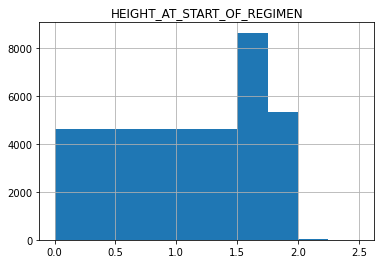

In [18]:
df.hist(column='HEIGHT_AT_START_OF_REGIMEN',bins=[0,1.5,1.75,2.0,2.25,2.5])

In [19]:
df = add_aggregate(df,what='median',target='HEIGHT_AT_START_OF_REGIMEN',groupby='MERGED_PATIENT_ID',name='NORMALISED_HEIGHT')
df.shape
# median_heights = df[(df['SEX'] == 2) & ~(df['HEIGHT_AT_START_OF_REGIMEN'].isnull())]['HEIGHT_AT_START_OF_REGIMEN'].median()

lost:  0


(59263, 64)

array([[<AxesSubplot:title={'center':'WEIGHT_AT_START_OF_REGIMEN'}>]],
      dtype=object)

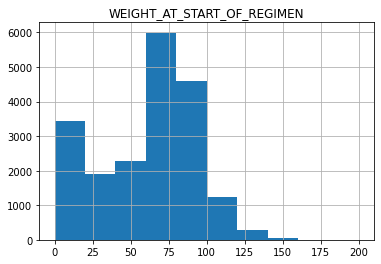

In [20]:
df.hist(column='WEIGHT_AT_START_OF_REGIMEN',bins=[0,20,40,60,80,100,120,140,160,180,200])

In [21]:
df = add_aggregate(df,what='median',target='WEIGHT_AT_START_OF_REGIMEN',groupby='MERGED_PATIENT_ID',name='NORMALISED_WEIGHT')
df.shape
# df['NORMALISED_WEIGHT'] = df[['WEIGHT_AT_START_OF_REGIMEN','MERGED_PATIENT_ID']][~df.WEIGHT_AT_START_OF_REGIMEN.isnull()].groupby(['MERGED_PATIENT_ID'])['WEIGHT_AT_START_OF_REGIMEN'].transform('median')
# df['NORMALISED_WEIGHT'] = df[['NORMALISED_WEIGHT','MERGED_PATIENT_ID']].groupby(['MERGED_PATIENT_ID'])['NORMALISED_WEIGHT'].transform('max')



lost:  0


(59263, 65)

In [22]:
df = merge(df, sact_cycle, how='left', on='MERGED_REGIMEN_ID', suffixes=(None, '_r'))
df.shape

(94259, 70)

In [23]:
df = df.drop(columns=['CONSULTANT_SPECIALITY_CODE','PRIMARY_DIAGNOSIS','MORPHOLOGY_CLEAN','MERGED_REGIMEN_ID'])
df = df.drop(columns=['HEIGHT_AT_START_OF_REGIMEN','WEIGHT_AT_START_OF_REGIMEN','INTENT_OF_TREATMENT'])
df = df.drop(columns=['DATE_DECISION_TO_TREAT','START_DATE_OF_REGIMEN','MAPPED_REGIMEN','BENCHMARK_GROUP'])
# df = df.drop(columns=['CLINICAL_TRIAL','CHEMO_RADIATION'])
df = df.drop(columns=['MERGED_CYCLE_ID','CYCLE_NUMBER','START_DATE_OF_CYCLE','OPCS_PROCUREMENT_CODE','PERF_STATUS_START_OF_CYCLE'])
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(94259, 54)
(59263, 54)


In [24]:
if OPTION == 0:
    to_csv(df, f'{path}/bt.csv')
elif OPTION == 1:
    to_csv(df, f'{path}/lung.csv')
elif OPTION == 2:
    to_csv(df, f'{path}/breast.csv')



In [26]:
len(set(df["TUMOURID"]))

41369